In [1]:
import cudf

In [2]:
df = cudf.read_parquet('../data/american_stories_1938_1945.parquet')

In [3]:
!nvidia-smi

Fri Feb  7 21:45:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| 30%   35C    P2             57W /  250W |    5282MiB /  32760MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 4368788 entries, 0 to 4368787
Data columns (total 8 columns):
 #   Column          Dtype
---  ------          -----
 0   article_id      object
 1   newspaper_name  object
 2   edition         object
 3   date            object
 4   page            object
 5   headline        object
 6   byline          object
 7   article         object
dtypes: object(8)
memory usage: 3.9+ GB


In [5]:
# Convert date column to datetime
df['date'] = cudf.to_datetime(df['date'])

In [6]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 4368788 entries, 0 to 4368787
Data columns (total 8 columns):
 #   Column          Dtype
---  ------          -----
 0   article_id      object
 1   newspaper_name  object
 2   edition         object
 3   date            datetime64[ns]
 4   page            object
 5   headline        object
 6   byline          object
 7   article         object
dtypes: datetime64[ns](1), object(7)
memory usage: 3.9+ GB


In [7]:
# Group by date and count articles per day
articles_per_day = df.groupby('date').size().reset_index(name='article_count')
articles_per_day.head(5)

,date,article_count
0,1944-07-21,1584
1,1942-06-07,1724
2,1942-11-29,1226
3,1943-06-15,1005
4,1942-09-09,1518


In [8]:
type(articles_per_day)

cudf.core.dataframe.DataFrame

In [9]:
articles_per_day.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   date           2922 non-null   datetime64[ns]
 1   article_count  2922 non-null   int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 45.7 KB


In [13]:
# Extract year from date and find the most common year
articles_per_day['year'] = articles_per_day['date'].dt.year
most_common_year = articles_per_day['year'].value_counts().head(10)
print("\nMost common year in the dataset:")
print(most_common_year)



Most common year in the dataset:
year
1940    366
1944    366
1938    365
1942    365
1945    365
1943    365
1939    365
1941    365
Name: count, dtype: int64


In [14]:
# Extract month and find most common year-month combination
articles_per_day['month'] = articles_per_day['date'].dt.month
year_month = articles_per_day.groupby(['year', 'month']).size().reset_index(name='count')
most_common_year_month = year_month.nlargest(5, 'count')

print("\nMost common year-month combinations:")
print(most_common_year_month)


Most common year-month combinations:
   year  month  count
1  1938     10     31
2  1939     12     31
3  1940      1     31
4  1944      3     31
5  1941     10     31


In [15]:
# Calculate average articles per day
avg_articles = articles_per_day['article_count'].mean()
print(f"\nAverage number of articles per day: {avg_articles:.2f}")


Average number of articles per day: 1495.14


In [16]:
# Get day with most articles
max_articles_day = articles_per_day.nlargest(1, 'article_count')
print("\nDay with most articles:")
print(max_articles_day)


Day with most articles:
           date  article_count  year  month
1158 1939-01-05           2797  1939      1


In [ ]:
# !pip install matplotlib

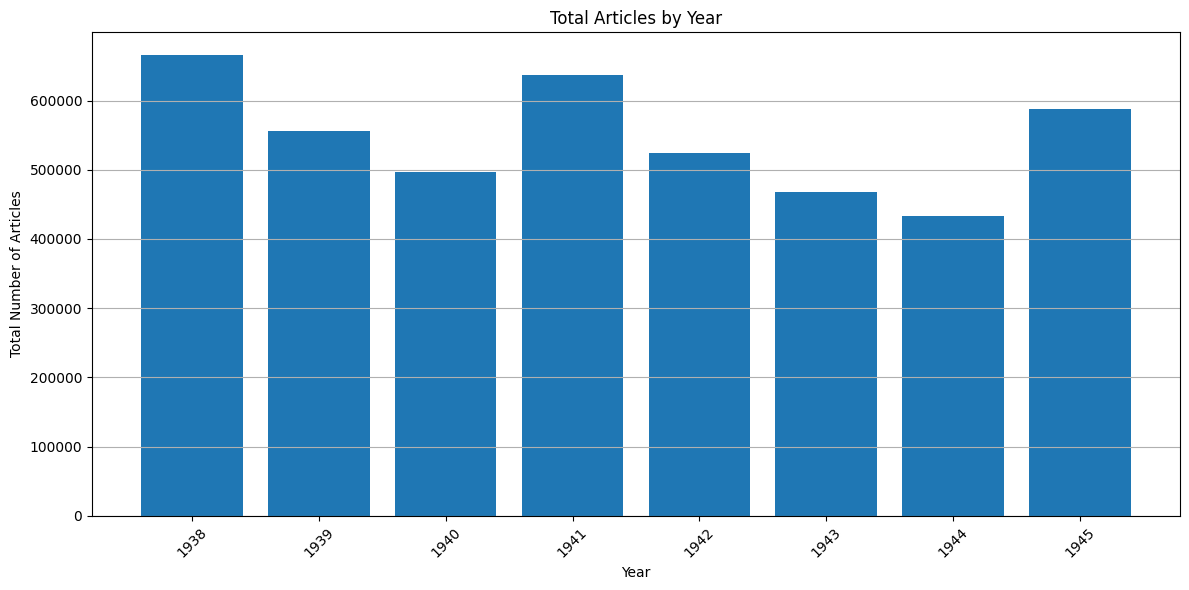

In [17]:
import matplotlib.pyplot as plt
# Plot frequency distribution of years
# Create a bar plot of articles by year
plt.figure(figsize=(12,6))
year_totals = articles_per_day.groupby('year')['article_count'].sum()
# Convert cudf Series directly to numpy arrays
plt.bar(year_totals.index.to_numpy(), year_totals.to_numpy())
plt.title('Total Articles by Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Articles')
plt.grid(True, axis='y')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
